# Playground, Machine Learning Final Project
### Something with exoplanets! 

In [1]:
# Importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patches as patches

# Importing sklearn libraries
import sklearn
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For optimizing hyper parameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# For selecting features
import shap

# Importing other libraries to measure time and create loading bars
from tqdm.notebook import tqdm
import time

# Statistical libraries
from scipy import stats

In [28]:
# Inspecting data we want to use for training
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/archive/q1_q8_koi_2025.02.03_04.12.15.csv'

# Step 1: Find the header line (starts with 'kepid' and not a comment)
with open(path, 'r') as f:
    lines = f.readlines()

# Step 2: Locate the line number containing the actual header
header_line = None
for i, line in enumerate(lines):
    if not line.startswith('#') and 'kepid' in line:
        header_line = i
        break

# Step 3: Load the CSV from that line onward
df = pd.read_csv(path, skiprows = header_line)
df_original = df.copy()                                 # Keep a copy of the original DataFrame

# Printing the dataframe in a nice format
print(df.head())  # Display the first few rows of the DataFrame


     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  9388479  K00936.02  Kepler-732 c       CONFIRMED        CANDIDATE   
1  8359498  K00127.01   Kepler-77 b       CONFIRMED        CANDIDATE   
2  9406990  K00937.01  Kepler-733 b       CONFIRMED        CANDIDATE   
3  9415172  K00938.01  Kepler-255 c       CONFIRMED        CANDIDATE   
4  9415172  K00938.02  Kepler-255 d       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0        NaN            NaN            NaN            NaN            NaN  ...   
1        NaN            NaN            NaN            NaN            NaN  ...   
2        NaN            NaN            NaN            NaN            NaN  ...   
3        NaN            NaN            NaN            NaN            NaN  ...   
4        NaN            NaN            NaN            NaN            NaN  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \
0     

In [3]:
# Variable count
print(df['koi_disposition'].value_counts())

koi_disposition
CONFIRMED            2317
FALSE POSITIVE        701
NOT DISPOSITIONED     579
CANDIDATE             268
Name: count, dtype: int64


In [4]:
# Defining the binary target variables
df = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]
df['label'] = df['koi_disposition'].map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})

# Print the binary target variables to ensure correctness
print(df['label'].value_counts())

label
1    2317
0     701
Name: count, dtype: int64


In [5]:
# ------------ Cleaning the data ------------
# Drop ID/name columns and non-predictive fields
X = df.drop(columns=[
    'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'label'
], errors='ignore')

# Drop columns with too many missing values (e.g. >30%)
X = X.loc[:, X.isnull().mean() < 0.3]

# Fill missing values
X = X.fillna(X.median())

y = df['label']

In [6]:
# Print the cleaned DataFrame and target variable
print(X.head())  # Display the first few rows of the cleaned DataFrame
print(y.value_counts())  # Display the counts of the target variable

   koi_period  koi_period_err1  koi_period_err2  koi_time0bk  \
0    0.893048     2.800000e-06    -2.800000e-06   134.538140   
1    3.578783     5.400000e-07    -5.400000e-07   134.029405   
2   20.834950     1.800000e-04    -1.800000e-04   176.578000   
3    9.946049     6.700000e-05    -6.700000e-05   171.700300   
4    1.045632     1.400000e-05    -1.400000e-05   133.914100   

   koi_time0bk_err1  koi_time0bk_err2  koi_impact  koi_impact_err1  \
0          0.000380         -0.000380       0.750             0.21   
1          0.000051         -0.000051       0.025             0.10   
2          0.003200         -0.003200       0.340             0.99   
3          0.002400         -0.002400       0.830             0.13   
4          0.002400         -0.002400       0.770             0.18   

   koi_impact_err2  koi_duration  ...  koi_steff_err2  koi_slogg  \
0            -0.21        1.1894  ...          -200.0       4.76   
1            -0.10        2.8982  ...           -50.0     

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)         # Stratify ensures that the distribution of classes is preserved in both training and testing sets

# Print the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (2414, 28), Test set shape: (604, 28)


In [8]:
# Training a simple MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes = (10, 10), activation = 'relu', solver = 'adam', max_iter = 500, random_state = 42, verbose = False, learning_rate = 'invscaling')

# Fitting the model
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10), learning_rate='invscaling',
              max_iter=500, random_state=42)

PermutationExplainer explainer: 2415it [00:24, 64.76it/s]                           
/var/folders/ws/45wzf3p157x_56fnsrq6bc4w0000gn/T/ipykernel_14758/1258499913.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type = "bar", max_display = 20)


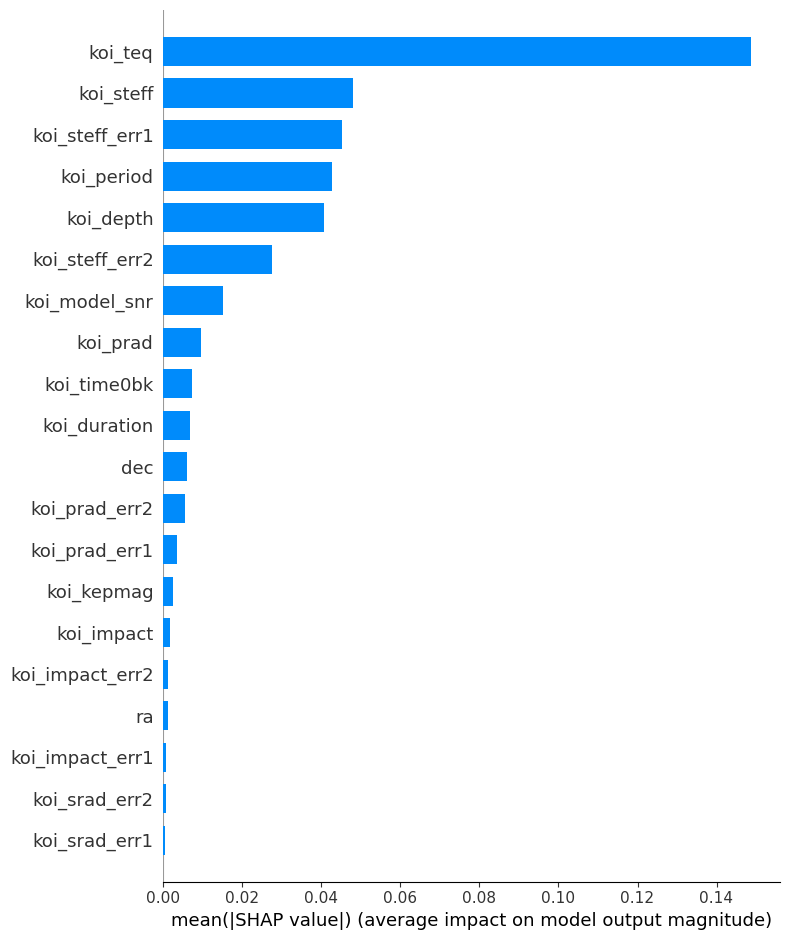

In [9]:
# ----- SHAP values for feature importance -----
explainer = shap.Explainer(classifier.predict, X_train)
shap_values = explainer(X_train)

# Plotting the SHAP values
shap.summary_plot(shap_values, X_train, plot_type = "bar", max_display = 20)

In [10]:
mean_shap_values = np.abs(shap_values.values).mean(axis = 0)
sorted_indicies = np.argsort(mean_shap_values)
sorted_shap = mean_shap_values[sorted_indicies][-25:][::-1]                   # This gets the top 25 features
sorted_shap_names = X_train.columns[sorted_indicies][-25:][::-1]              # This gets the names of the top 25 features

# Printing the top 25 features using Pandas
print('--------- Top 25 features ---------')
top_25_features = pd.Series(sorted_shap, index = sorted_shap_names)
display(top_25_features)

--------- Top 25 features ---------


koi_teq            0.148627
koi_steff          0.048015
koi_steff_err1     0.045173
koi_period         0.042598
koi_depth          0.040622
koi_steff_err2     0.027431
koi_model_snr      0.015190
koi_prad           0.009587
koi_time0bk        0.007298
koi_duration       0.006738
dec                0.006081
koi_prad_err2      0.005565
koi_prad_err1      0.003426
koi_kepmag         0.002549
koi_impact         0.001594
koi_impact_err2    0.001220
ra                 0.001164
koi_impact_err1    0.000619
koi_srad_err2      0.000569
koi_srad_err1      0.000448
koi_srad           0.000425
koi_slogg          0.000376
koi_period_err2    0.000131
koi_slogg_err1     0.000098
koi_period_err1    0.000043
dtype: float64

In [11]:
# Choosing which parameters to include in the model
N = [5, 10, 12, 15, 20, 22, 25]                                     # Number of parameters to test

accuracy = []                                                       # List to store accuracy
computing_time = []                                                 # List to store computing time

fpr = []                                                            # List to store false positive rate
tpr = []                                                            # List to store true positive rate
roc_auc = []                                                        # List to store area under the curve

# Making the training data a Pandas DataFrame to easily access the columns
X_dataframe = pd.DataFrame(X_train, columns = X_train.columns)

# Looping through the number of parameters
for n in tqdm(N):

    # Selecting the top n features
    X_features_n = X_dataframe[sorted_shap_names[:n]]
    y_matched = y.loc[X_features_n.index]

    # Splitting the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_features_n, y_matched, test_size = 0.2, random_state = 42, stratify = y_matched)  # Stratify ensures that the distribution of classes is preserved in both training and validation sets

    # Fitting the model and timing it 
    start = time.time()
    classifier = MLPClassifier(hidden_layer_sizes = (10, 10), activation = 'relu', solver = 'adam', max_iter = 500, random_state = 42, verbose = False, learning_rate = 'invscaling')
    classifier.fit(X_train, y_train)                                                # Fitting the model
    end = time.time()

    computing_time.append(end - start)                                              # Appending the time to the list

    # Getting the accuracy 
    y_pred = classifier.predict(X_val)
    accuracy.append(accuracy_score(y_val, y_pred))                                  # Appending the accuracy to the list

    # Getting the false positive rate, true positive rate, and area under the curve
    predictions = classifier.predict_proba(X_val)                                   # This gets the predicted probabilities
    predictions = pd.DataFrame(predictions, columns = ['False', 'True'])            # This makes it a DataFrame (False = not electron, True = electron)
    fpr_, tpr_, _ = roc_curve(y_val, predictions['True'])                           # This gets the false positive rate and true positive rate
    roc_auc_ = auc(fpr_, tpr_)                                                      # This gets the area under the curve

    fpr.append(fpr_)                                                                # Appending the false positive rate to the list
    tpr.append(tpr_)                                                                # Appending the true positive rate to the list
    roc_auc.append(roc_auc_)                                                        # Appending the area under the curve to the list

  0%|          | 0/7 [00:00<?, ?it/s]

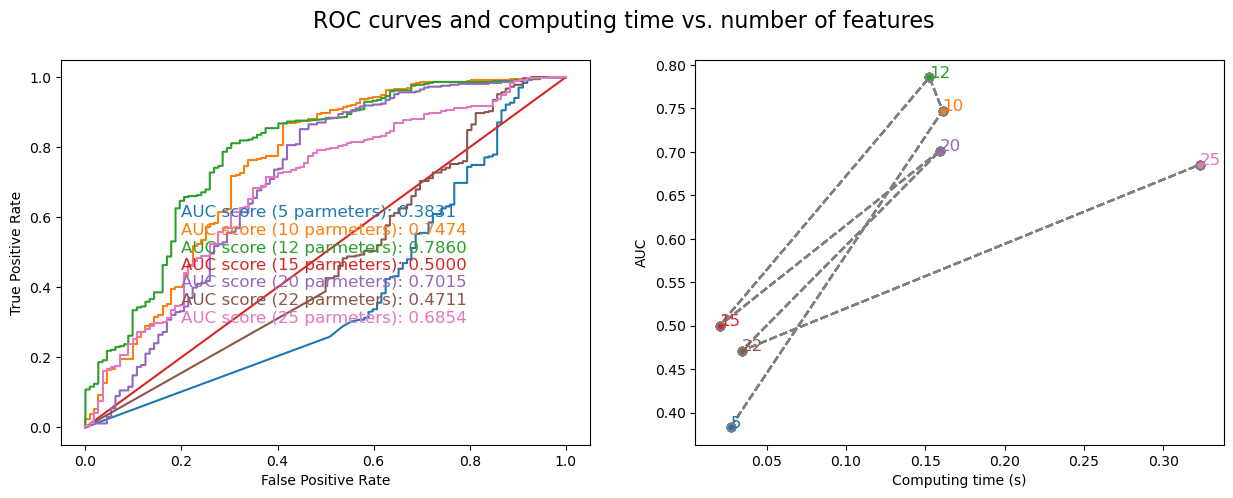

In [12]:
# Plotting ROC curves and computing time to compare the models and the number of features
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(len(N)):
    
    # ----- Plotting ROC curves -----
    ax[0].plot(fpr[i], tpr[i], label = f'ROC curve (area = {roc_auc[i]:.2f}) with {N[i]} features')
    ax[0].set_xlabel('False Positive Rate')                                                             
    ax[0].set_ylabel('True Positive Rate')                                                              

    ax[0].text(0.2, 0.6-i/20, f'AUC score ({N[i]} parmeters): {roc_auc[i]:.4f}', color = f'C{i}', fontsize = 12)

    # Plotting AUC vs. computing time
    ax[1].plot(computing_time, roc_auc, 'o--', label = f'{N[i]} features', color = 'grey', zorder = 1)    # This plots the AUC vs. computing time
    ax[1].scatter(computing_time[i], roc_auc[i], color = f'C{i}', s = 10, zorder = 2)                     
    ax[1].text(computing_time[i], roc_auc[i], f'{N[i]}', color = f'C{i}', fontsize = 12)
    ax[1].set_xlabel('Computing time (s)')                                                              
    ax[1].set_ylabel('AUC')                                                                             
    
fig.suptitle('ROC curves and computing time vs. number of features', fontsize = 16)
plt.show()

Based on this, it seems like 12 parameters gives the best result!

In [13]:
# Moving forward with 12 features and now testing hyper parameters
# First defining the parameters we want to test (using GridSearch)
param_grid = {
    'hidden_layer_sizes': [(10, 10), (20, 20), (30, 30)],
    'max_iter': [100, 1000, 10000, 30000],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Defining the model
model_test_hyperparams = MLPClassifier(random_state = 42, activation = 'relu', solver = 'adam', verbose = False)

# Grid search
grid_search = GridSearchCV(estimator = model_test_hyperparams, param_grid = param_grid, scoring = 'accuracy', return_train_score = True, refit = True)

In [14]:
# Splitting the data into training and validation sets, using the top 12 features
X_features_12 = X_dataframe[sorted_shap_names[:12]]
y_matched = y.loc[X_features_12.index]

X_train, X_val, y_train, y_val = train_test_split(X_features_12, y_matched, test_size = 0.2, random_state = 42, stratify = y_matched)  # Stratify ensures that the distribution of classes is preserved in both training and validation sets

In [15]:
# Performing the grid search on dataset with 12 features
grid_search.fit(X_train, y_train);

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

In [16]:
# Getting the best parameters
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')                # This prints the best parameters

Best parameters: {'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 100}


In [17]:
# Making the final model with best no. of features and best hyperparameters
final_model = MLPClassifier(
    hidden_layer_sizes = best_params['hidden_layer_sizes'],
    max_iter = best_params['max_iter'],
    learning_rate = best_params['learning_rate'],
    activation = 'relu',
    solver = 'adam',
    random_state = 42,
    verbose = False
)

# Fitting the final model
final_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=100, random_state=42)

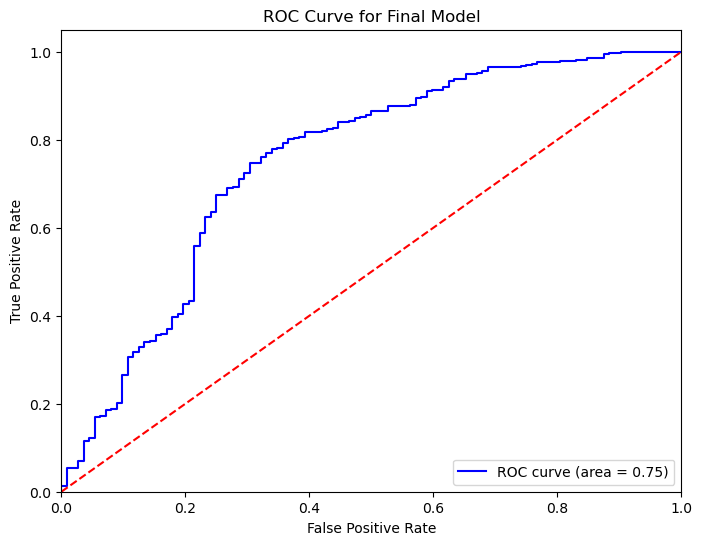

In [18]:
# Making predictions
y_pred = final_model.predict(X_val)
y_proba = final_model.predict_proba(X_val)

# Printing the classification report
#print(classification_report(y_val, y_pred))

# Plotting the ROC curve for the final model
fpr_final, tpr_final, _ = roc_curve(y_val, y_proba[:, 1])
roc_auc_final = auc(fpr_final, tpr_final)

plt.figure(figsize = (8, 6))
plt.plot(fpr_final, tpr_final, color = 'blue', label = f'ROC curve (area = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Model')
plt.legend(loc = 'lower right')

Not the best model, but could be worse...

In [19]:
# New try; were we scale the data to improve performance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train.value_counts(normalize = True)

label
1    0.767478
0    0.232522
Name: proportion, dtype: float64

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


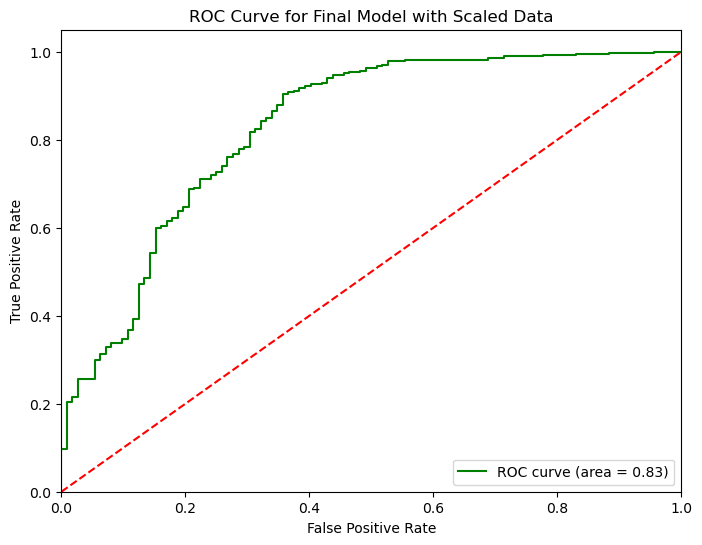

In [20]:
# Fitting the final model with scaled data to test if it improves performance
final_model_scaled = MLPClassifier(
    hidden_layer_sizes = best_params['hidden_layer_sizes'],
    max_iter = best_params['max_iter'],
    learning_rate = best_params['learning_rate'],
    activation = 'relu',
    solver = 'adam',
    random_state = 42,
    verbose = False
)

# Fitting the final model with scaled data
final_model_scaled.fit(X_train_scaled, y_train)

# Making predictions with scaled data
y_pred_scaled = final_model_scaled.predict(X_val_scaled)
y_proba_scaled = final_model_scaled.predict_proba(X_val_scaled)

# Printing the classification report for scaled data
#print(classification_report(y_val, y_pred_scaled))

# Plotting the ROC curve for the final model with scaled data
fpr_final_scaled, tpr_final_scaled, _ = roc_curve(y_val, y_proba_scaled[:, 1])
roc_auc_final_scaled = auc(fpr_final_scaled, tpr_final_scaled)

plt.figure(figsize = (8, 6))
plt.plot(fpr_final_scaled, tpr_final_scaled, color = 'green', label = f'ROC curve (area = {roc_auc_final_scaled:.2f})')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Model with Scaled Data')
plt.legend(loc = 'lower right')

Scaling seems to improve it a bit!

In [21]:
# Trying to also balance the data using the SMOTE technique
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


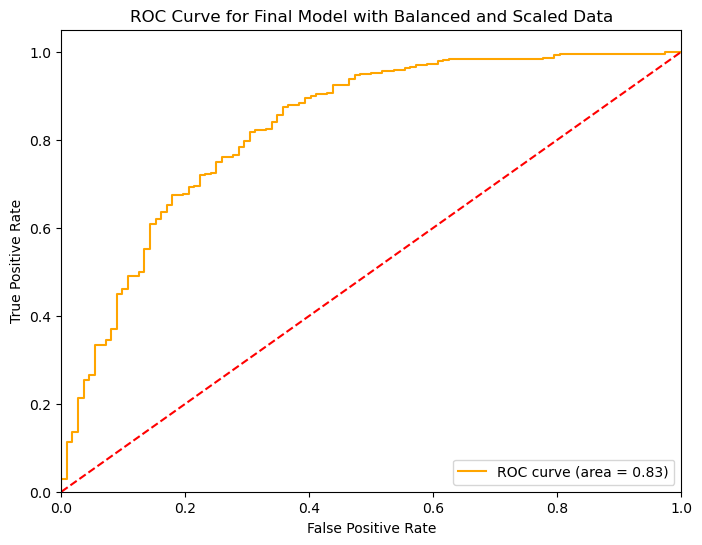

In [22]:
# Fitting the final model with balanced AND scaled data
final_model_balanced = MLPClassifier(
    hidden_layer_sizes = best_params['hidden_layer_sizes'],
    max_iter = best_params['max_iter'],
    learning_rate = best_params['learning_rate'],
    activation = 'relu',
    solver = 'adam',
    random_state = 42,
    verbose = False
)

# Fitting the final model with balanced and scaled data
final_model_balanced.fit(X_train_balanced, y_train_balanced)

# Making predictions with balanced and scaled data
y_pred_balanced = final_model_balanced.predict(X_val_scaled)
y_proba_balanced = final_model_balanced.predict_proba(X_val_scaled)

# Printing the classification report for balanced and scaled data
#print(classification_report(y_val, y_pred_balanced))

# Plotting the ROC curve for the final model with balanced and scaled data
fpr_final_balanced, tpr_final_balanced, _ = roc_curve(y_val, y_proba_balanced[:, 1])
roc_auc_final_balanced = auc(fpr_final_balanced, tpr_final_balanced)

plt.figure(figsize = (8, 6))
plt.plot(fpr_final_balanced, tpr_final_balanced, color = 'orange', label = f'ROC curve (area = {roc_auc_final_balanced:.2f})')
plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Model with Balanced and Scaled Data')
plt.legend(loc = 'lower right')

Even better! Now we can try and make predictions on the unlabeled data - i.e., not (yet) confirmed exoplanets. 

In [32]:
candidates = df_original[df_original['koi_disposition'] == 'CANDIDATE'].copy()

# Selecting the top 12 features from the candidates
X_candidates = candidates[sorted_shap_names[:12]]
X_candidates = X_candidates.fillna(X_train.median())                # Fill missing values with the median of the training set

# Scaling the candidates data
X_candidates_scaled = scaler.transform(X_candidates)

# Making predictions on the candidates data
y_candidates_pred = final_model_balanced.predict(X_candidates_scaled)
y_candidates_proba = final_model_balanced.predict_proba(X_candidates_scaled)

candidates['predicted_class'] = y_candidates_pred
candidates['predicted_prob_confirmed'] = y_candidates_proba[:, 1]

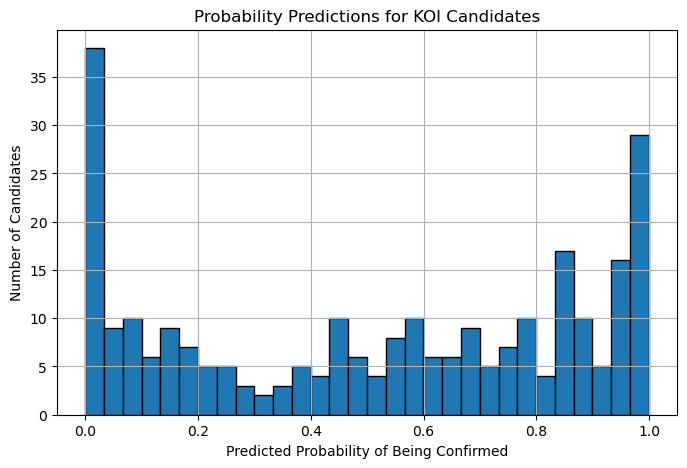

In [33]:
plt.figure(figsize = (8, 5))
plt.hist(candidates['predicted_prob_confirmed'], bins = 30, edgecolor = 'black')
plt.xlabel('Predicted Probability of Being Confirmed')
plt.ylabel('Number of Candidates')
plt.title('Probability Predictions for KOI Candidates')
plt.grid(True)
plt.show()

In [34]:
# Getting the top ranked candidates based on the predicted probability of being confirmed
top_preds = candidates.sort_values(by = 'predicted_prob_confirmed', ascending = False)
print(top_preds[['kepoi_name', 'koi_period', 'koi_prad', 'koi_steff', 'predicted_prob_confirmed']].head(10))

     kepoi_name  koi_period  koi_prad  koi_steff  predicted_prob_confirmed
607   K00141.01    2.624234      5.43     5425.0                  0.999238
1327  K01463.01  580.000000     16.29     6020.0                  0.999136
3514  K00531.01    3.687469      3.00     4091.0                  0.999047
1342  K01597.01    7.796734      2.68     6443.0                  0.998891
3589  K00005.01    4.780329      5.66     5861.0                  0.997759
3198  K00368.01  110.321605     18.90     9257.0                  0.997452
298   K00883.01    2.688898     11.12     4859.0                  0.997129
3221  K00607.01    5.893991      7.20     5497.0                  0.996990
3624  K00319.01   46.151590      7.50     5952.0                  0.996729
3788  K00626.02    8.029010      0.96     6157.0                  0.994705


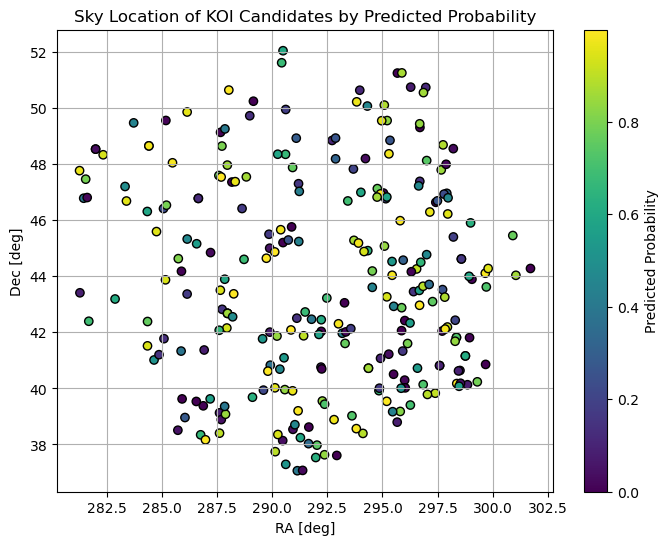

In [35]:
plt.figure(figsize = (8, 6))
sc = plt.scatter(
    candidates['ra'], candidates['dec'],
    c = candidates['predicted_prob_confirmed'], cmap = 'viridis', edgecolor = 'k'
)
plt.colorbar(sc, label = 'Predicted Probability')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('Sky Location of KOI Candidates by Predicted Probability')
plt.grid(True)
plt.show()